In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/dl_asnmt3/
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1n1TNAkd_eMq63pCUSBX6Rd76dAcpmw_2/dl_asnmt3
/content/drive/.shortcut-targets-by-id/1n1TNAkd_eMq63pCUSBX6Rd76dAcpmw_2/dl_asnmt3


### All commented things have been tried

In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import models
from torch.optim import lr_scheduler
import os
import time
import gc
import shutil
import h5py
import random
%matplotlib inline

## Defining sequence generator function

In [10]:
def generate_seq(sqlen):
    letters = ['a','b','c','d','E','B']
    spclxy = ['x','y']
    embds = np.eye(8, dtype=np.float32)
    emb_map = {'a':embds[0], 'b':embds[1], 'c':embds[2], 'd':embds[3], 'x':embds[4], 'y':embds[5], 'E':embds[6], 'B':embds[7]}
    class_emb = np.eye(8, dtype=np.float32)
    class_map = {'Q':0, 'R':1, 'S':2, 'U':3, 'V':4, 'A':5, 'B':6, 'C':7}
    conditions = {'xxx':'Q', 'xxy':'R', 'xyx':'S', 'xyy':'U', 'yxx':'V', 'yxy':'A', 'yyx':'B', 'yyy':'C'}
    # sqlen = random.randint(100,110)
    t1 = random.randint(10,20)
    t2 = random.randint(33,43)
    t3 = random.randint(66,76)
    cursqn = []
    sqnemb = []
    cursqn.append('E')
    xysq = ''
    for i in range(sqlen):
        if i==t1 or i==t2 or i==t3:
            r = random.randint(0,1)
            cursqn.append(spclxy[r])
            xysq += spclxy[r]
        else:
            r = random.randint(0,3)
            cursqn.append(letters[r])
    cursqn.append('B')
    # print(cursqn)
    for i in range(sqlen+2):
        sqnemb.append(emb_map[cursqn[i]])
    sqembmat = torch.tensor(sqnemb)
    # target = torch.tensor(class_emb[class_map[conditions[xysq]]])
    target = torch.tensor(class_map[conditions[xysq]])
    tgt_1hot = [0 for i in range(8)]
    tgt_1hot[target.item()] = 1
    tgt_1hot = torch.tensor(tgt_1hot)
    # print(sqembmat.shape)
    return sqembmat, target, tgt_1hot

# print(generate_seq())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q4_checkpoints/q4_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(device, model_class, ckpt, test_data):
    model = model_class().cuda()
    print(model)
    checkpoint = torch.load('q4_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # test_loader = DataLoader(test_data, 64, num_workers=2, pin_memory=True)  
    # sm = nn.Softmax(dim=1)  
    total_correct = 0
    itrs = 3000
    for i in range(itrs):
        inputs, labels = generate_seq()
        # print(labels)
        inputs = inputs.unsqueeze(0).to(self.device)
        labels = labels.unsqueeze(0).to(self.device)
        # print(labels.shape)
        with torch.set_grad_enabled(False):
            outputs = self.model(inputs)
            # print(outputs.shape)
            # print(outputs)
            loss = self.criterion(outputs, labels)
            losses += loss.detach().cpu().item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            labels = labels.item()
            outputs = torch.argmax(outputs, dim=1)
            total_correct += (outputs == labels).sum().item()
        torch.cuda.empty_cache()
        gc.collect()
        model_accuracy = total_correct/itrs*100
    return model_accuracy

def plot_train(losses):
    seqdone = [i*1000 for i in range(len(losses))]
    plt.plot(seqdone, losses, label = "Train loss", color='blue')#, markersize=5, marker='o',markerfacecolor='blue')
    plt.xlabel('Number of training sequences')
    plt.ylabel('Loss')
    plt.title('Train loss vs. number of sequences')
    plt.legend()
    plt.show()

In [22]:
class Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, epochs=100, batch_size=200, lr=0.1, optm='adam', lr_decay=None, weight_decay=0):
        self.device = device
        self.lr =  lr
        self.momentum = 0.9
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.itrs = 1000
        self.seed = int(time.time())
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_epoch = 0
        self.best_loss = 1e8
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class().cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.01, momentum=self.momentum)
        self.criterion = nn.CrossEntropyLoss().cuda()
        # self.criterion = nn.MSELoss()
        
        if self.checkpoint_path:
            checkpoint = torch.load('q3_checkpoints/'+self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            self.best_loss = checkpoint['best_loss']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        acc = 0
        for epoch in range(self.start_epoch, self.epochs):
            prev_acc = acc
            loss, acc = self.train_epoch(epoch)
            if loss < self.best_loss:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            seqdone = (epoch+1)*self.itrs
            self.loss_history.append(loss)
            self.best_loss = min(loss, self.best_loss)
            print('Sequences:'+str(seqdone),'  Loss:'+str(round(loss,3)),'  Accuracy:'+str(round(acc,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'best_loss': self.best_loss,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            if acc==100 and prev_acc==100 and loss<0.1:
                break
            # input()
        return self.best_epoch, self.loss_history

    def train_epoch(self, cur_epoch):    
        self.model.train()        
        losses = 0
        # itrs = 1000
        total_correct = 0
        smax = nn.Softmax(dim=1)
        for i in range(self.itrs//self.batch_size):
            sqlen = random.randint(100,110)
            all_inputs, all_labels, all_embs = [], [], []
            for b in range(self.batch_size):
                inputs, labels, embs = generate_seq(sqlen)
                all_inputs.append(inputs)
                all_labels.append(labels)
                all_embs.append(embs)
            inputs = torch.stack(all_inputs).cuda()
            labels = torch.stack(all_labels).cuda()
            label_emb = torch.stack(all_embs).cuda()
            # print(inputs.shape,labels.shape)
            # label_emb = [0 for j in range(8)]
            # label_emb[labels.item()] = 1
            # label_emb = torch.tensor(label_emb).unsqueeze(0).cuda()
            # label_emb = torch.nn.functional.one_hot(labels,num_classes=8).cuda()
            # print(label_emb.shape)
            # print(label_emb)
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                # print(type(inputs), inputs)
                outputs = self.model(inputs)
                # print(outputs.shape)
                # print(outputs)
                loss = self.criterion(outputs, labels)
                # print(self.model.lstm1.weight_hh_l0.grad) 
                # loss = self.criterion(outputs, label_emb.float())
                # loss.register_hook(lambda grad: print(grad))
                loss.backward()
                self.optimizer.step()
                # labels = labels.item()
                losses += loss.detach().cpu().item()
                outputs = torch.argmax(outputs, dim=1)
                total_correct += (outputs == labels).sum().item()
                # outputs = smax(outputs)
                # print(torch.abs(label_emb - outputs))
                # total_correct += ((torch.abs(label_emb - outputs) >= 0.3).sum(dim=1) == 0).sum().item()
            torch.cuda.empty_cache()
            gc.collect()
        return losses/(self.itrs//self.batch_size), total_correct/self.itrs*100

##Training RNN  
3 RNN layers with 2,4,8 cell/output sizes  
Relu nonlinearity  
Weights initialization : [-0.1,0.1]  
1 Dense layer  
Loss is CrossEntropy   
Learning Rate = 0.1  
optimizer= Adam  
Metrices: Accuracy as given in question

In [32]:
class MyRNN(nn.Module):
    def __init__(self, input_size=8, output_size=8, hidden_dim=[2,4,8], n_layers=1):
        super(MyRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn1 = nn.RNN(input_size, hidden_dim[0], n_layers, batch_first=True)
        self.init_weights(self.rnn1,-2.0)
        self.rnn2 = nn.RNN(hidden_dim[0], hidden_dim[1], n_layers, batch_first=True)
        self.init_weights(self.rnn2,-4.0)
        self.rnn3 = nn.RNN(hidden_dim[1], hidden_dim[2], n_layers, batch_first=True)
        self.init_weights(self.rnn3,-6.0)
        self.fc = nn.Linear(hidden_dim[2], output_size)
        self.init_weights(self.fc,0)
    
    def forward(self, x):
        # print(x.shape)
        batch_size = x.size(0)
        out, hidden = self.rnn1(x)
        out, hidden = self.rnn2(out)
        out, hidden = self.rnn3(out)
        output = hidden
        # print(output.shape)
        output = self.fc(output)
        output = output.squeeze(0)
        return output
    
    def init_hidden(self, batch_size, hidden_dim):
        # hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = torch.FloatTensor(self.n_layers, batch_size, hidden_dim).uniform_(-0.1, 0.1)
        return hidden

    def init_weights(self, model, bias):
        for name, param in model.named_parameters():
            if 'weight' in name:
                torch.nn.init.uniform_(param, -0.1, 0.1)

cuda Tesla T4
Sequences:1000   Loss:2.18   Accuracy:12.6
Sequences:2000   Loss:2.382   Accuracy:11.4
Sequences:3000   Loss:2.263   Accuracy:14.1
Sequences:4000   Loss:2.75   Accuracy:13.8
Sequences:5000   Loss:2.578   Accuracy:12.7
Sequences:6000   Loss:2.754   Accuracy:13.8
Sequences:7000   Loss:2.435   Accuracy:13.9
Sequences:8000   Loss:2.222   Accuracy:12.2
Sequences:9000   Loss:2.195   Accuracy:11.6
Sequences:10000   Loss:2.135   Accuracy:13.1
Sequences:11000   Loss:2.148   Accuracy:12.0
Sequences:12000   Loss:2.093   Accuracy:14.1
Sequences:13000   Loss:2.093   Accuracy:12.1
Sequences:14000   Loss:2.09   Accuracy:12.3
Sequences:15000   Loss:2.093   Accuracy:13.1
Sequences:16000   Loss:2.092   Accuracy:12.4
Sequences:17000   Loss:2.086   Accuracy:12.8
Sequences:18000   Loss:2.092   Accuracy:13.0
Sequences:19000   Loss:2.089   Accuracy:13.3
Sequences:20000   Loss:2.092   Accuracy:13.4
Sequences:21000   Loss:2.103   Accuracy:11.3
Sequences:22000   Loss:2.093   Accuracy:13.6
Sequence

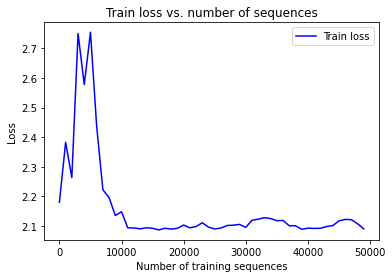

Best epoch: 16


In [23]:
### seq len between 100 to 110

trainer1 = Trainer(device, MyRNN, 'rnn', lr=0.1, epochs=50, optm='rms')
base_best_epoch1, base_losses1 = trainer1.train()
plot_train(base_losses1)
print('Best epoch:',base_best_epoch1)

cuda Tesla T4
Sequences:1000   Loss:1.736   Accuracy:1.4
Sequences:2000   Loss:0.43   Accuracy:61.6
Sequences:3000   Loss:0.033   Accuracy:100.0
Sequences:4000   Loss:0.011   Accuracy:100.0


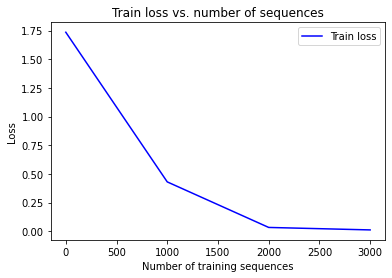

Best epoch: 3


In [ ]:
''' Tried with seqlen = 8'''

trainer2 = Trainer(device, MyRNN, 'rnntry', lr=0.01, epochs=10)
base_best_epoch2, base_losses2 = trainer2.train()
plot_train(base_losses2)
print('Best epoch:',base_best_epoch2)

## Training LSTM  

3 RNN layers with 2,4,8 cell/output sizes
Default TanH nonlinearity
Weights initialization : [-0.1,0.1] 
Input gate bias initialization : -2.0, -4.0, -6.0  
1 Dense layer
Loss is CrossEntropy
Learning Rate = 0.1
optimizer= Adam
Metrices: Accuracy as given in question

In [26]:
class MyLSTM(nn.Module):
    def __init__(self, input_size=8, output_size=8, hidden_dim=[2,4,8], n_layers=1):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm1 = nn.LSTM(input_size, hidden_dim[0], n_layers, batch_first=True)
        self.init_weights(self.lstm1,-2.0)
        self.lstm2 = nn.LSTM(hidden_dim[0], hidden_dim[1], n_layers, batch_first=True)
        self.init_weights(self.lstm2,-4.0)
        self.lstm3 = nn.LSTM(hidden_dim[1], hidden_dim[2], n_layers, batch_first=True)
        self.init_weights(self.lstm3,-6.0)
        self.fc = nn.Linear(hidden_dim[2], output_size)
        # self.act = nn.ReLU()
        # self.init_weights(self.fc,0)
    
    def forward(self, x):
        # print(x.shape)
        batch_size = x.size(0)
        out, (hidden, cell) = self.lstm1(x)
        out, (hidden, cell) = self.lstm2(out)
        out, (hidden, cell) = self.lstm3(out)
        output = hidden
        # print(output.shape)
        output = self.fc(output)
        # print(output.shape)
        # output = self.act(output)
        output = output.squeeze(0)
        return output
    
    def init_states(self, batch_size, hidden_dim):
        # hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = torch.FloatTensor(self.n_layers, batch_size, hidden_dim).uniform_(-0.1, 0.1)
        cell = torch.FloatTensor(self.n_layers, batch_size, hidden_dim).uniform_(-0.1, 0.1)
        return hidden, cell

    def init_weights(self, model, bias):
        for name, param in model.named_parameters():
            # print(name)
            if 'bias' in name:
                # continue
                # print(param.shape)
                # print(param)
                nn.init.constant_(param[:param.size(0)//4], bias)
                nn.init.constant_(param[param.size(0)//4:], 0)
                # print(param)
            if 'weight' in name:
                torch.nn.init.uniform_(param, -0.1, 0.1)

cuda Tesla T4
Sequences:1000   Loss:2.102   Accuracy:11.6
Sequences:2000   Loss:2.099   Accuracy:13.4
Sequences:3000   Loss:2.098   Accuracy:11.5
Sequences:4000   Loss:2.087   Accuracy:12.4
Sequences:5000   Loss:2.083   Accuracy:12.3
Sequences:6000   Loss:2.087   Accuracy:13.2
Sequences:7000   Loss:2.087   Accuracy:11.2
Sequences:8000   Loss:2.086   Accuracy:12.9
Sequences:9000   Loss:2.088   Accuracy:13.9
Sequences:10000   Loss:2.084   Accuracy:13.0
Sequences:11000   Loss:2.092   Accuracy:11.0
Sequences:12000   Loss:2.083   Accuracy:12.5
Sequences:13000   Loss:2.085   Accuracy:14.5
Sequences:14000   Loss:2.088   Accuracy:13.0
Sequences:15000   Loss:2.086   Accuracy:12.5
Sequences:16000   Loss:2.083   Accuracy:12.9
Sequences:17000   Loss:2.096   Accuracy:10.6
Sequences:18000   Loss:2.089   Accuracy:10.9
Sequences:19000   Loss:2.091   Accuracy:10.4
Sequences:20000   Loss:2.087   Accuracy:10.3
Sequences:21000   Loss:2.085   Accuracy:11.5
Sequences:22000   Loss:2.087   Accuracy:11.5
Seque

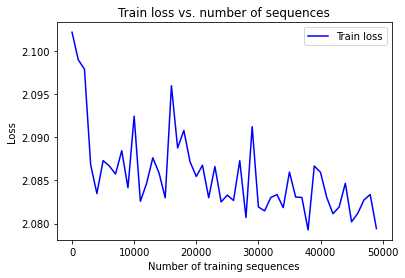

Best epoch: 38


In [29]:
''' with seqlen 100 to 110'''
trainer3 = Trainer(device, MyLSTM, 'lstm', lr=0.1, epochs=50, optm='rms')
base_best_epoch3, base_losses3 = trainer3.train()
plot_train(base_losses3)
print('Best epoch:',base_best_epoch3)

cuda Tesla T4
Sequences:1000   Loss:1.543   Accuracy:12.2
Sequences:2000   Loss:0.158   Accuracy:88.8
Sequences:3000   Loss:0.014   Accuracy:100.0
Sequences:4000   Loss:0.004   Accuracy:100.0


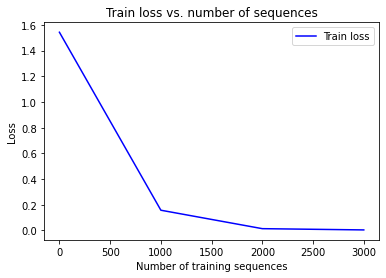

Best epoch: 3


In [ ]:
'''tried with seqlen 8'''

trainer2 = Trainer(device, MyLSTM, 'lstmtry', lr=0.01, epochs=10)
base_best_epoch2, base_losses2 = trainer2.train()
plot_train(base_losses2)
print('Best epoch:',base_best_epoch2)